In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, './..')
sys.path.insert(0, '../data')

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec
import proplot as pplt
from tqdm import tqdm

import numpy as np
import torch
from torchvision import datasets, transforms

from models import eval
from models import model as model_loader
import plots as pl
from utils import dev, load_data, classification

sys.path.insert(0, './../../')

import response_contour_analysis.utils.model_handling as model_utils
import response_contour_analysis.utils.dataset_generation as data_utils
import response_contour_analysis.utils.histogram_analysis as hist_utils
import response_contour_analysis.utils.principal_curvature as curve_utils
import response_contour_analysis.utils.plotting as plot_utils

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


# Experiment parameters

In [2]:
hess_params = dict()
hess_params['hessian_num_pts'] = 1.0e4
hess_params['hessian_lr'] = 1e-4
hess_params['hessian_random_walk'] = False
hess_params['return_points'] = False
hess_params['lr_decay'] = False#True
num_iters = 2 # for paired image boundary search
num_steps_per_iter = 100 # for paired image boundary search
buffer_portion = 0.25
num_eps = 1000
batch_size = 1000
num_images = 50#labels_nat.size
hess_radius_mult = 0.7 # times the min adv perturbation length
num_advs = 8
autodiff = True
load = False
num_hessian_tests = 0#10

# Load data & models

In [3]:
seed = 0

# load data
data_natural = np.load(f'../data/natural_{seed}.npy', allow_pickle=True).item()
advs_nat = data_natural['advs']
pert_lengths_nat = data_natural['pert_lengths']
classes_nat = data_natural['adv_class']
dirs_nat = data_natural['dirs']
images_nat = data_natural['images']
labels_nat = data_natural['labels']

data_madry = np.load(f'../data/robust_{seed}.npy', allow_pickle=True).item()
advs_madry = data_madry['advs']
pert_lengths_madry = data_madry['pert_lengths']
classes_madry = data_madry['adv_class']
dirs_madry = data_madry['dirs']
images_madry = data_madry['images']
labels_madry = data_madry['labels']

In [4]:
sub_pert_lengths_nat = pert_lengths_nat[:, :num_advs]
sub_pert_lengths_madry = pert_lengths_madry[:, :num_advs]
mean_pert_lengths = np.mean([sub_pert_lengths_nat[np.isfinite(sub_pert_lengths_nat)].mean(),
                             sub_pert_lengths_madry[np.isfinite(sub_pert_lengths_madry)].mean()])
min_pert_lengths = np.min([sub_pert_lengths_nat[np.isfinite(sub_pert_lengths_nat)].min(),
                             sub_pert_lengths_madry[np.isfinite(sub_pert_lengths_madry)].min()])
hess_params['hessian_dist'] = min_pert_lengths * hess_radius_mult # radius around the target image

In [5]:
# load models (all data assumes you are using the _diff model)
model_natural = model_loader.madry_diff()
model_madry = model_loader.madry_diff()
model_random = model_loader.madry_diff()

model_natural.load_state_dict(torch.load(f'./../models/natural_{seed}.pt', map_location=DEVICE))
model_natural.to(DEVICE)

model_madry.load_state_dict(torch.load(f'./../models/robust_{seed}.pt', map_location=DEVICE))
model_madry.to(DEVICE)

model_random.load_state_dict(torch.load('./../models/random.pt', map_location=DEVICE))
model_random.to(DEVICE)

madry_diff(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (elu): ELU(alpha=1.0)
)

In [6]:
def torchify(img):
    output = torch.from_numpy(img).type(torch.DoubleTensor).to(DEVICE) # always autodiff
    return output


def get_paired_boundary_image(model, origin, alt_image, num_steps_per_iter, num_iters):
    input_shape = (1,)+origin.shape
    def find_pert(image_line):
        correct_lbl = torch.argmax(model(torchify(image_line[0, ...].reshape(input_shape))))
        pert_lbl = correct_lbl.clone()
        step_idx = 1 # already know the first one
        while pert_lbl == correct_lbl:
            pert_image = image_line[step_idx, ...]
            pert_lbl = torch.argmax(model(torchify(pert_image.reshape(input_shape))))
            step_idx += 1
        return step_idx-1, pert_image
    image_line = np.linspace(origin.reshape(-1), alt_image.reshape(-1), num_steps_per_iter)
    for search_iter in range(num_iters):
        step_idx, pert_image = find_pert(image_line)
        image_line = np.linspace(image_line[step_idx - 1, ...], image_line[step_idx, ...], num_steps_per_iter)
    delta_image = origin.reshape(-1) - pert_image
    pert_length = np.linalg.norm(delta_image)
    direction = delta_image / pert_length
    return pert_image.reshape(origin.shape), direction, pert_length


def generate_paired_dict(data_dict, model, num_images, num_advs):
    image_shape = data_dict['images'].shape[1:]
    num_pixels = int(np.prod(image_shape))
    images = np.zeros((num_images,) + image_shape)
    labels = np.zeros((num_images), dtype=np.int)
    dirs = np.zeros((num_images, num_advs, 1, num_pixels))
    advs = np.zeros((num_images, num_advs, 1, num_pixels))
    pert_lengths = np.zeros((num_images, num_advs))
    adv_class = np.zeros((num_images, num_advs))
    model_predictions = torch.argmax(model(torchify(data_dict['images'])), dim=1).detach().cpu().numpy()
    valid_indices = []
    for image_idx in range(data_dict['images'].shape[0]):
        if model_predictions[image_idx] == data_dict['labels'][image_idx]:
            valid_indices.append(image_idx)
    origin_indices = np.random.choice(valid_indices, size=num_images, replace=False)
    for image_idx, origin_idx in enumerate(origin_indices):
        images[image_idx, ...] = data_dict['images'][origin_idx, ...]
        labels[image_idx] = data_dict['labels'][origin_idx]
        shuffled_valid_indices = np.random.choice(valid_indices, size=len(valid_indices), replace=False)
        alt_indices = [idx for idx, alt_class in zip(shuffled_valid_indices, data_dict['labels'][shuffled_valid_indices]) if alt_class != labels[image_idx]]
        for dir_idx, alt_idx in enumerate(alt_indices[:num_advs]):
            alt_image = data_dict['images'][alt_idx, ...]
            boundary_image, boundary_dir, pert_length = get_paired_boundary_image(
                model, images[image_idx, ...], alt_image, num_steps_per_iter, num_iters)
            dirs[image_idx, dir_idx, ...] = boundary_dir.reshape(1, -1)
            advs[image_idx, dir_idx, ...] = boundary_image.reshape(1, -1)
            adv_class[image_idx,  dir_idx] = torch.argmax(model(torchify(boundary_image[None, ...]))).item()
            pert_lengths[image_idx, dir_idx] =  pert_length
    output_dict = {}
    output_dict['images'] = images
    output_dict['labels'] = labels
    output_dict['dirs'] = dirs
    output_dict['advs'] = advs
    output_dict['adv_class'] = adv_class
    output_dict['pert_lengths'] = pert_lengths
    return output_dict


def paired_activation(model, image, neuron1, neuron2):
    if not image.requires_grad:
        image.requires_grad = True
    model.zero_grad()
    activation1 = model_utils.unit_activation(model, image, neuron1, compute_grad=True)
    activation2 = model_utils.unit_activation(model, image, neuron2, compute_grad=True)
    activation_difference = activation1 - activation2
    return activation_difference


def paired_activation_and_gradient(model, image, neuron1, neuron2):
    activation_difference = paired_activation(model, image, neuron1, neuron2)
    grad = torch.autograd.grad(activation_difference, image)[0]
    return activation_difference, grad


def get_curvature(condition_zip, num_images, num_advs, num_eps, batch_size, buffer_portion, autodiff=False):
    """
    A note on the gradient of the difference in activations:
        The gradient points in the direction of the origin from the boundary image.
        Therefore, for large enough eps, origin - eps * grad/|grad| will reach the boundary; and boundary + eps * grad/|grad| will reach the origin 
    """
    models, model_data = zip(*condition_zip)
    num_models = len(models)
    image_shape = model_data[0]['images'][0, ...][None, ...].shape
    image_size = np.prod(image_shape)
    num_dims = image_size - 1 #removes orthogonal direction
    shape_operators = np.zeros((num_models, num_images, num_advs, num_dims, num_dims))
    principal_curvatures = np.zeros((num_models, num_images, num_advs, num_dims))
    principal_directions = np.zeros((num_models, num_images, num_advs, image_size, num_dims))
    origin_indices = np.zeros((num_models, num_images), dtype=np.int)
    for model_idx, (model, data)  in enumerate(zip(models, model_data)):
        model_predictions = torch.argmax(model(torchify(data['images'])), dim=1).detach().cpu().numpy()
        valid_indices = [] # Need to ensure that all images are correctly labeled & have valid adversarial examples
        for image_idx in range(data['images'].shape[0]):
            if model_predictions[image_idx] == data['labels'][image_idx]: # correctly labeled
                if np.all(np.isfinite(data['pert_lengths'][image_idx, :num_advs])): # enough adversaries found
                    adv_predictions = data['advs']
                    valid_indices.append(image_idx)
        origin_indices[model_idx, :] = np.random.choice(valid_indices, size=num_images, replace=False)
        pbar = tqdm(total=num_images, leave=False)
        for image_idx, origin_idx in enumerate(list(origin_indices[model_idx, :])):
            clean_lbl = int(data['labels'][origin_idx])
            for adv_idx in range(num_advs):
                boundary_image = get_paired_boundary_image(
                    model=model,
                    origin=data['images'][origin_idx, ...],
                    alt_image=data['advs'][origin_idx, adv_idx, ...],
                    num_steps_per_iter=num_steps_per_iter,
                    num_iters=num_iters
                )[0]
                adv_lbl = int(data['adv_class'][origin_idx, adv_idx])
                activation, gradient = paired_activation_and_gradient(model, torchify(boundary_image[None,...]), clean_lbl, adv_lbl)
                gradient = gradient.reshape(-1)
                if autodiff:
                    def func(x):
                        acts_diff = paired_activation(model, x, clean_lbl, adv_lbl)
                        return acts_diff
                    hessian = torch.autograd.functional.hessian(func, torchify(boundary_image[None,...]))
                    hessian = hessian.reshape((int(boundary_image.size), int(boundary_image.size)))
                else:
                    def func(x):
                        acts_diff, grad = paired_activation_and_gradient(model, x, clean_lbl, adv_lbl)
                        return acts_diff, grad
                    torch_image = torchify(boundary_image[None,...])
                    torch_image.requires_grad = True
                    hessian = curve_utils.sr1_hessian(
                        func, torch_image,
                        distance=hess_params['hessian_dist'],
                        n_points=hess_params['hessian_num_pts'],
                        random_walk=hess_params['hessian_random_walk'],
                        learning_rate=hess_params['hessian_lr'],
                        return_points=False,
                        progress=False)
                #curvature = curve_utils.local_response_curvature_isoresponse_surface(gradient, hessian)
                curvature = curve_utils.local_response_curvature_graph(gradient, hessian)
                shape_operators[model_idx, image_idx, adv_idx, ...] = curvature[0].detach().cpu().numpy()
                principal_curvatures[model_idx, image_idx, adv_idx, :] = curvature[1].detach().cpu().numpy()
                principal_directions[model_idx, image_idx, adv_idx, ...] = curvature[2].detach().cpu().numpy()
            pbar.update(1)
        pbar.close()
    return shape_operators, principal_curvatures, principal_directions, origin_indices


def get_hessian_error(model, origin, clean_lbl, adv_lbl, abscissa, ordinate, hess_params):
    def act_func(x):
        acts_diff = paired_activation(model, x, clean_lbl, adv_lbl)
        return acts_diff
    def act_grad_func(x):
        acts_diff, grad = paired_activation_and_gradient(model, x, clean_lbl, adv_lbl)
        return acts_diff, grad
    origin.requires_grad = True
    sr1_hessian = curve_utils.sr1_hessian(
        act_grad_func, origin,
        distance=hess_params['hessian_dist'],
        n_points=hess_params['hessian_num_pts'],
        random_walk=hess_params['hessian_random_walk'],
        learning_rate=hess_params['hessian_lr'],
        return_points=False,
        progress=True)
    autodiff_hessian = torch.autograd.functional.hessian(act_func, origin)
    autodiff_hessian = autodiff_hessian.reshape((int(origin.numel()), int(origin.numel())))
    n_x_samples = 10
    n_y_samples = 100
    x = np.linspace(-hess_params['hessian_dist']/2, hess_params['hessian_dist']/2, n_x_samples)
    y = np.linspace(-hess_params['hessian_dist']*1.25, hess_params['hessian_dist']*1.25, n_y_samples)
    X, Y = np.meshgrid(x, y)
    samples = (abscissa * X.reshape((-1, 1)) + ordinate * Y.reshape((-1, 1))).reshape((-1,) + origin.shape[1:])
    samples = origin + torchify(samples)
    exact_response = act_func(samples)
    sr1_approx_response = curve_utils.hessian_approximate_response(act_grad_func, samples, sr1_hessian)
    autodiff_approx_response = curve_utils.hessian_approximate_response(act_grad_func, samples, autodiff_hessian)
    sr1_total_error = (exact_response - sr1_approx_response)
    autodiff_total_error = (exact_response - autodiff_approx_response)
    sr1_rms_error = np.sqrt(np.mean(np.square(sr1_total_error.detach().cpu().numpy())))
    autodiff_rms_error = np.sqrt(np.mean(np.square(autodiff_total_error.detach().cpu().numpy())))
    return sr1_rms_error, autodiff_rms_error

In [7]:
if num_hessian_tests > 0:
    sr1_errors = []
    autodiff_errors = []
    valid_indices = [i for i in range(data_natural['images'].shape[0]) if np.isfinite(data_natural['pert_lengths'][i, 2])]
    image_indices = np.random.choice(valid_indices, size=num_hessian_tests, replace=False)
    for image_idx in image_indices:
        adv_idx = 0
        boundary_image, boundary_dir, pert_length = get_paired_boundary_image(
            model=model_natural,
            origin=data_natural['images'][image_idx, ...],
            alt_image=data_natural['advs'][image_idx, adv_idx, ...],
            num_steps_per_iter=num_steps_per_iter,
            num_iters=num_iters
        )

        sr1_rms_error, autodiff_rms_error = get_hessian_error(
            model=model_natural,
            origin=torchify(boundary_image[None,...]),
            clean_lbl=int(data_natural['labels'][image_idx]),
            adv_lbl=int(data_natural['adv_class'][image_idx, adv_idx]),
            abscissa=boundary_dir,
            ordinate=data_natural['advs'][image_idx, adv_idx+1],
            hess_params=hess_params
        )
        sr1_errors.append(sr1_rms_error)
        autodiff_errors.append(autodiff_rms_error)

    print(f'Average RMS error over {num_hessian_tests} images with an l2 radius of {hess_params["hessian_dist"]:.3f} for\nSR1 Hessian:\t\t{np.mean(sr1_errors):.3f}\nAutodiff hessian:\t{np.mean(autodiff_errors):.3f}.')

In [8]:
if autodiff:
    filename = '../data/curvatures_and_directions_autodiff.npz'
else:
    filename = '../data/curvatures_and_directions_sr1.npz'

if load:
    data = np.load(filename, allow_pickle=True)['data'].item()
    data_paired_natural = data['data_paired_natural']
    data_paired_madry = data['data_paired_madry']
    paired_shape_operators = data['paired_shape_operators']
    paired_principal_curvatures = data['paired_principal_curvatures']
    paired_principal_directions = data['paired_principal_directions']
    paired_mean_curvatures = data['paired_mean_curvatures']
    paired_origin_indices = data['paired_origin_indices']
    adv_shape_operators = data['adv_shape_operators']
    adv_principal_curvatures = data['adv_principal_curvatures']
    adv_principal_directions = data['adv_principal_directions']
    adv_mean_curvatures = data['adv_mean_curvatures']
    adv_origin_indices = data['adv_origin_indices']
    del data
else:
    data_paired_natural = generate_paired_dict(data_natural, model_natural, num_images, num_advs)
    data_paired_madry = generate_paired_dict(data_madry, model_madry, num_images, num_advs)
    paired_condition_zip = zip([model_natural, model_madry], [data_paired_natural, data_paired_madry])
    paired_shape_operators, paired_principal_curvatures, paired_principal_directions, paired_origin_indices = get_curvature(
        paired_condition_zip, num_images, num_advs, num_eps, batch_size, buffer_portion, autodiff)
    paired_mean_curvatures = np.mean(paired_principal_curvatures, axis=-1)
    adv_condition_zip = zip([model_natural, model_madry], [data_natural, data_madry])
    adv_shape_operators, adv_principal_curvatures, adv_principal_directions, adv_origin_indices = get_curvature(
        adv_condition_zip, num_images, num_advs, num_eps, batch_size, buffer_portion, autodiff)
    adv_mean_curvatures = np.mean(adv_principal_curvatures, axis=-1)
    save_dict = {
        'data_paired_natural':data_paired_natural,
        'data_paired_madry':data_paired_madry,
        'paired_shape_operators': paired_shape_operators,
        'paired_principal_curvatures': paired_principal_curvatures,
        'paired_principal_directions': paired_principal_directions,
        'paired_mean_curvatures': paired_mean_curvatures,
        'paired_origin_indices': paired_origin_indices,
        'adv_shape_operators': adv_shape_operators,
        'adv_principal_curvatures': adv_principal_curvatures,
        'adv_principal_directions': adv_principal_directions,
        'adv_mean_curvatures': adv_mean_curvatures,
        'adv_origin_indices': adv_origin_indices
    }
    np.savez(filename, data=save_dict)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
def test_model_and_data(data_nat, data_mad):
    diff_str = '_diff' if autodiff else '_nodiff'
    for model, data, name in zip([model_natural, model_madry], [data_nat, data_mad], ['natural'+diff_str, 'madry'+diff_str]):
        image_shape = data['images'][0,...].shape
        clean_count = 0
        adv_count = 0
        clean_imgs = torchify(data['images'])
        clean_model_predictions = torch.argmax(model(clean_imgs), dim=1).detach().cpu().numpy()
        for img_idx in range(data['images'].shape[0]):
            label = int(data['labels'][img_idx])
            prediction = int(clean_model_predictions[img_idx])
            #assert  prediction == label , f'{name}: img_idx={img_idx}; prediction={prediction}; label={label}'
            #if clean_model_predictions[img_idx] != data['labels'][img_idx]: print(f'{name}: img_idx={img_idx}; prediction={clean_model_predictions[img_idx]}; label={data["labels"][img_idx]}')
            if clean_model_predictions[img_idx] != data['labels'][img_idx]: clean_count += 1
            adv_imgs = torchify(data['advs'][img_idx, ...].reshape((-1,)+image_shape))
            adv_model_predictions = torch.argmax(model(adv_imgs), dim=1).detach().cpu().numpy()
            for adv_idx in range(data['adv_class'].shape[1]):
                if np.isfinite(data['pert_lengths'][img_idx, adv_idx]):
                    label = int(data['adv_class'][img_idx, adv_idx])
                    prediction = int(adv_model_predictions[adv_idx])
                    #assert  prediction == label, f'{name}: img_idx={img_idx}, adv_idx={adv_idx}, prediction={prediction}, adv_label={label}'
                    #if adv_model_predictions[adv_idx] != data['adv_class'][img_idx, adv_idx]: print(f'{name}: img_idx={img_idx}, adv_idx={adv_idx}, prediction={adv_model_predictions[adv_idx]}, label={data["adv_class"][img_idx, adv_idx]}')
                    if adv_model_predictions[adv_idx] != data['adv_class'][img_idx, adv_idx]: adv_count += 1
        print(f'{name}: number of clean images with bad predictions = {clean_count}; number of adv images with bad predictions = {adv_count}')

test_model_and_data(data_paired_natural, data_paired_madry)
test_model_and_data(data_natural, data_madry)

natural_diff: number of clean images with bad predictions = 0; number of adv images with bad predictions = 0
madry_diff: number of clean images with bad predictions = 0; number of adv images with bad predictions = 0
natural_diff: number of clean images with bad predictions = 0; number of adv images with bad predictions = 0
madry_diff: number of clean images with bad predictions = 0; number of adv images with bad predictions = 0


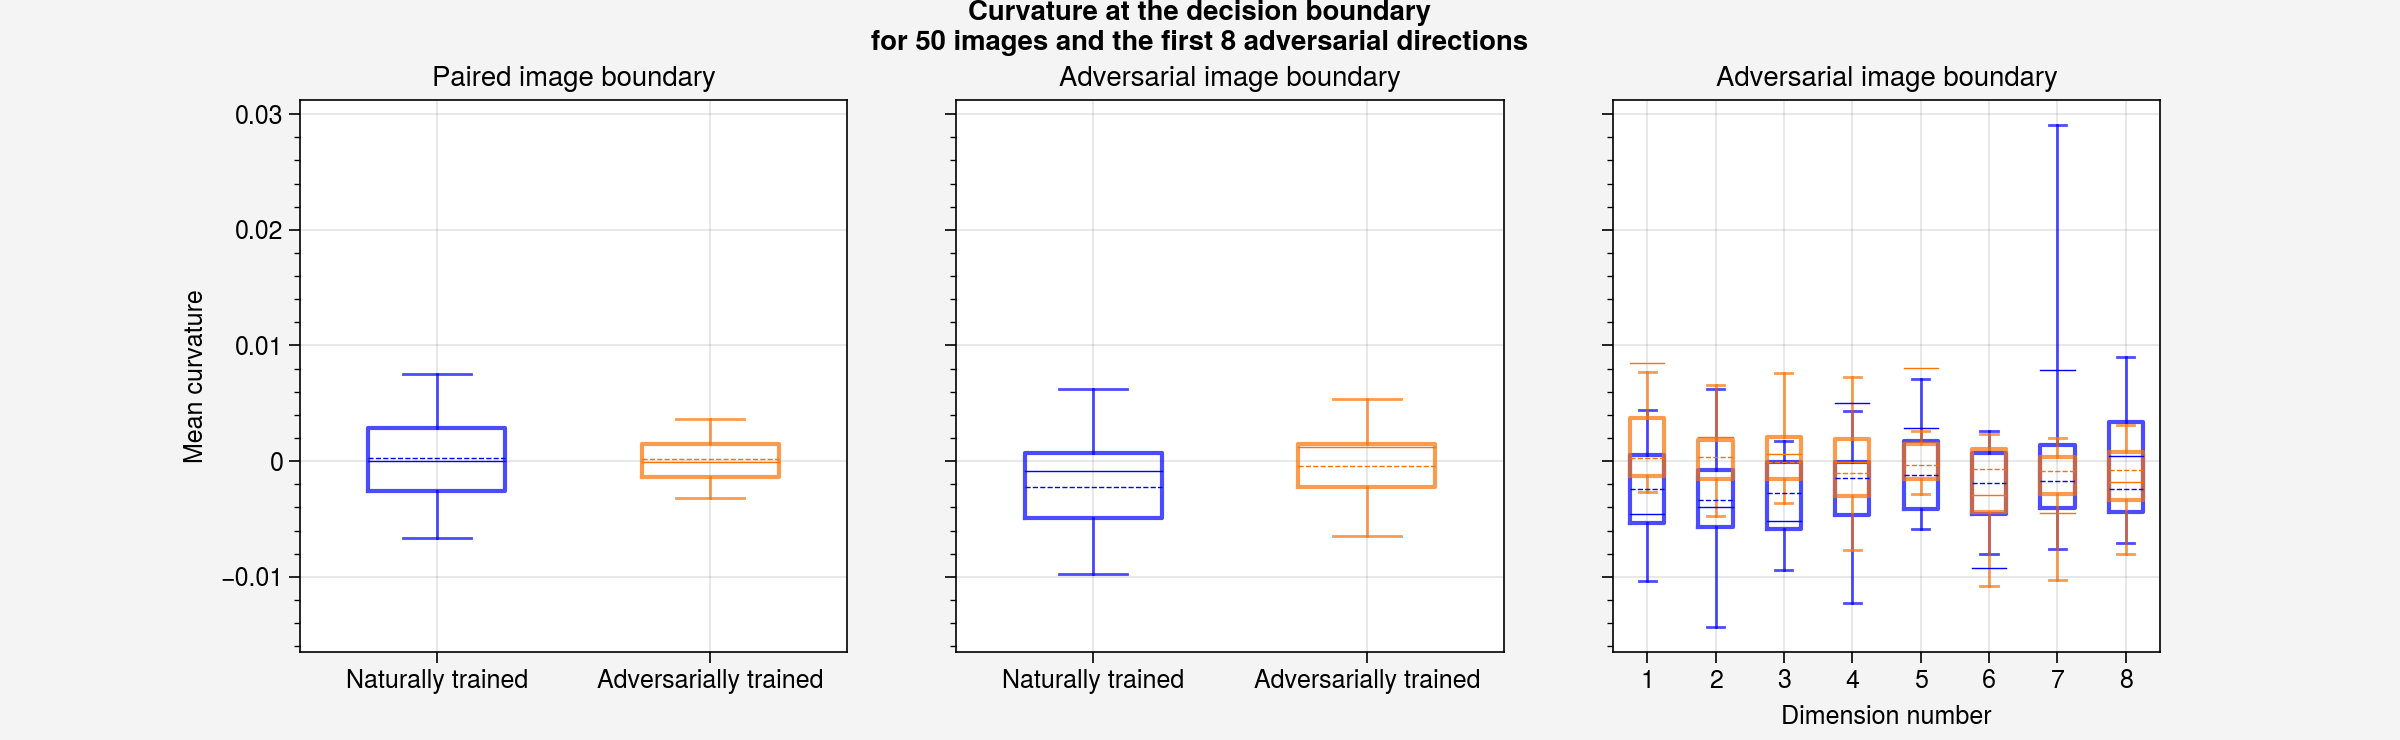

In [10]:
colors = ['blue', 'orange']
bar_width = 0.5
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,4))
fig.subplots_adjust(top=0.8)

for data_idx, mean_curvatures in enumerate([paired_mean_curvatures, adv_mean_curvatures]):
    for model_idx in range(2):
        boxprops = dict(color=colors[model_idx], linewidth=1.5, alpha=0.7)
        whiskerprops = dict(color=colors[model_idx], alpha=0.7)
        capprops = dict(color=colors[model_idx], alpha=0.7)
        medianprops = dict(linestyle='--', linewidth=0.5, color=colors[model_idx])
        meanpointprops = dict(marker='o', markeredgecolor='black',
                              markerfacecolor=colors[model_idx])
        meanprops = dict(linestyle='-', linewidth=0.5, color=colors[model_idx])
        data = mean_curvatures[model_idx, :, :].reshape(-1)
        axs[data_idx].boxplot(data, sym='', positions=[model_idx], whis=(10, 90), widths=bar_width, meanline=True, showmeans=True, boxprops=boxprops,
            whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, meanprops=meanprops)
    axs[data_idx].set_xticks([0, 1], minor=False)
    axs[data_idx].set_xticks([], minor=True)
    axs[data_idx].set_xticklabels(['Naturally trained', 'Adversarially trained'])
    if data_idx == 0:
        axs[data_idx].set_ylabel('Mean curvature')
        axs[data_idx].set_title('Paired image boundary')
    else:
        axs[data_idx].set_title('Adversarial image boundary')

for model_idx in range(adv_mean_curvatures.shape[0]):
    boxprops = dict(color=colors[model_idx], linewidth=1.5, alpha=0.7)
    whiskerprops = dict(color=colors[model_idx], alpha=0.7)
    capprops = dict(color=colors[model_idx], alpha=0.7)
    medianprops = dict(linestyle='--', linewidth=0.5, color=colors[model_idx])
    meanpointprops = dict(marker='o', markeredgecolor='black',
                          markerfacecolor=colors[model_idx])
    meanprops = dict(linestyle='-', linewidth=0.5, color=colors[model_idx])
    for adv_idx in range(adv_mean_curvatures.shape[-1]):
        data = adv_mean_curvatures[model_idx, :, adv_idx].reshape(-1)
        axs[2].boxplot(data, sym='', positions=[adv_idx], whis=(10, 90), widths=bar_width, meanline=True, showmeans=True, boxprops=boxprops,
            whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, meanprops=meanprops)
axs[2].set_title('Adversarial image boundary')
axs[2].set_xlabel('Dimension number')
axs[2].set_xticks([i for i in range(adv_mean_curvatures.shape[-1])], minor=False)
axs[2].set_xticks([], minor=True)
axs[2].set_xticklabels([str(i+1) for i in range(adv_mean_curvatures.shape[-1])])

def make_space_above(axes, topmargin=1):
    """ increase figure size to make topmargin (in inches) space for 
        titles, without changing the axes sizes
        obtained from: https://stackoverflow.com/a/55768955/
    """
    fig = axes.flatten()[0].figure
    s = fig.subplotpars
    w, h = fig.get_size_inches()

    figh = h - (1 - s.top) * h + topmargin
    fig.subplots_adjust(bottom=s.bottom*h/figh, top=1-topmargin/figh)
    fig.set_figheight(figh)

make_space_above(axs, topmargin=0.5)  

fig.suptitle(f'Curvature at the decision boundary\nfor {num_images} images and the first {num_advs} adversarial directions', y=1.0)
plt.show()
fig.savefig('../data/mean_curvature_boxplots.png', transparent=True, bbox_inches='tight', pad_inches=0.01)

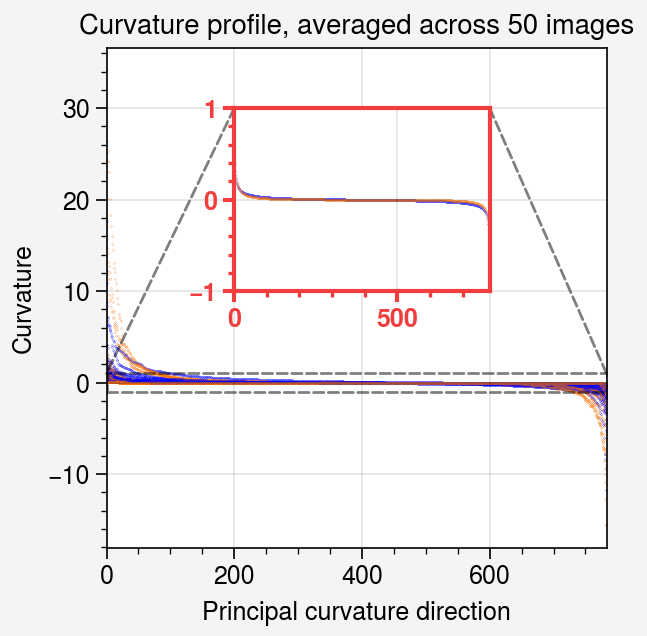

In [25]:
fig, ax = pplt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)
#ax[0].hist(adv_principal_curvatures[0,...].reshape(-1), width=0.5, color='k', log=True)
##bins = np.linspace(angle_min, angle_max, num_bins)
##hist, bin_edges = np.histogram(weight_angles.flatten(), bins)
##if y_max is None:
##y_max = np.max(hist)
##bin_left, bin_right = bin_edges[:-1], bin_edges[1:]
##bin_centers = bin_left + (bin_right - bin_left)/2
##fig, ax = plt.subplots(1, figsize=figsize)
##ax.bar(bin_centers, hist, width=2.0, log=True, align="center")
##ax[0].hist(paired_mean_curvatures, log=True)
#ax[0].format(
#    title=f'Histogram of curvatures for {num_images} images',
#    xlabel='Curvature',
#    ylabel='Count'
#)
num_models, num_images, num_advs, num_dims = adv_principal_curvatures.shape
for image_idx in range(num_images):
    for adv_idx in range(num_advs):
        ax.scatter(adv_principal_curvatures[0, image_idx, adv_idx, :], s=0.01, c='blue')
        ax.scatter(adv_principal_curvatures[1, image_idx, adv_idx, :], s=0.01, c='orange')
        
ix = ax.inset(
    bounds=[200, 10, 400, 20],
    transform='data', zoom=True,
    zoom_kw={'edgecolor': 'k', 'lw': 1, 'ls': '--'}
)
ix.format(
    xlim=(0, num_dims), ylim=(-1, 1), metacolor='red7',
    linewidth=1.5, ticklabelweight='bold'
)
#for image_idx in range(num_images):
#    for adv_idx in range(num_advs):
#        ix.scatter(adv_principal_curvatures[0, image_idx, adv_idx, :], s=0.005, alpha=0.5, c='blue')
#        ix.scatter(adv_principal_curvatures[1, image_idx, adv_idx, :], s=0.005, alpha=0.5, c='orange')
ix.scatter(adv_principal_curvatures[0, ...].mean(axis=(0, 1)), s=0.005, alpha=1.0, c='blue')
ix.scatter(adv_principal_curvatures[1, ...].mean(axis=(0, 1)), s=0.005, alpha=1.0, c='orange')

ax.format(
    title=f'Curvature profile, averaged across {num_images} images',
    xlim=(0, num_dims),
    ylabel='Curvature',
    xlabel='Principal curvature direction'
)
pplt.show()

#fig.savefig('../data/curvature_profile.png', transparent=True, bbox_inches='tight', pad_inches=0.01)

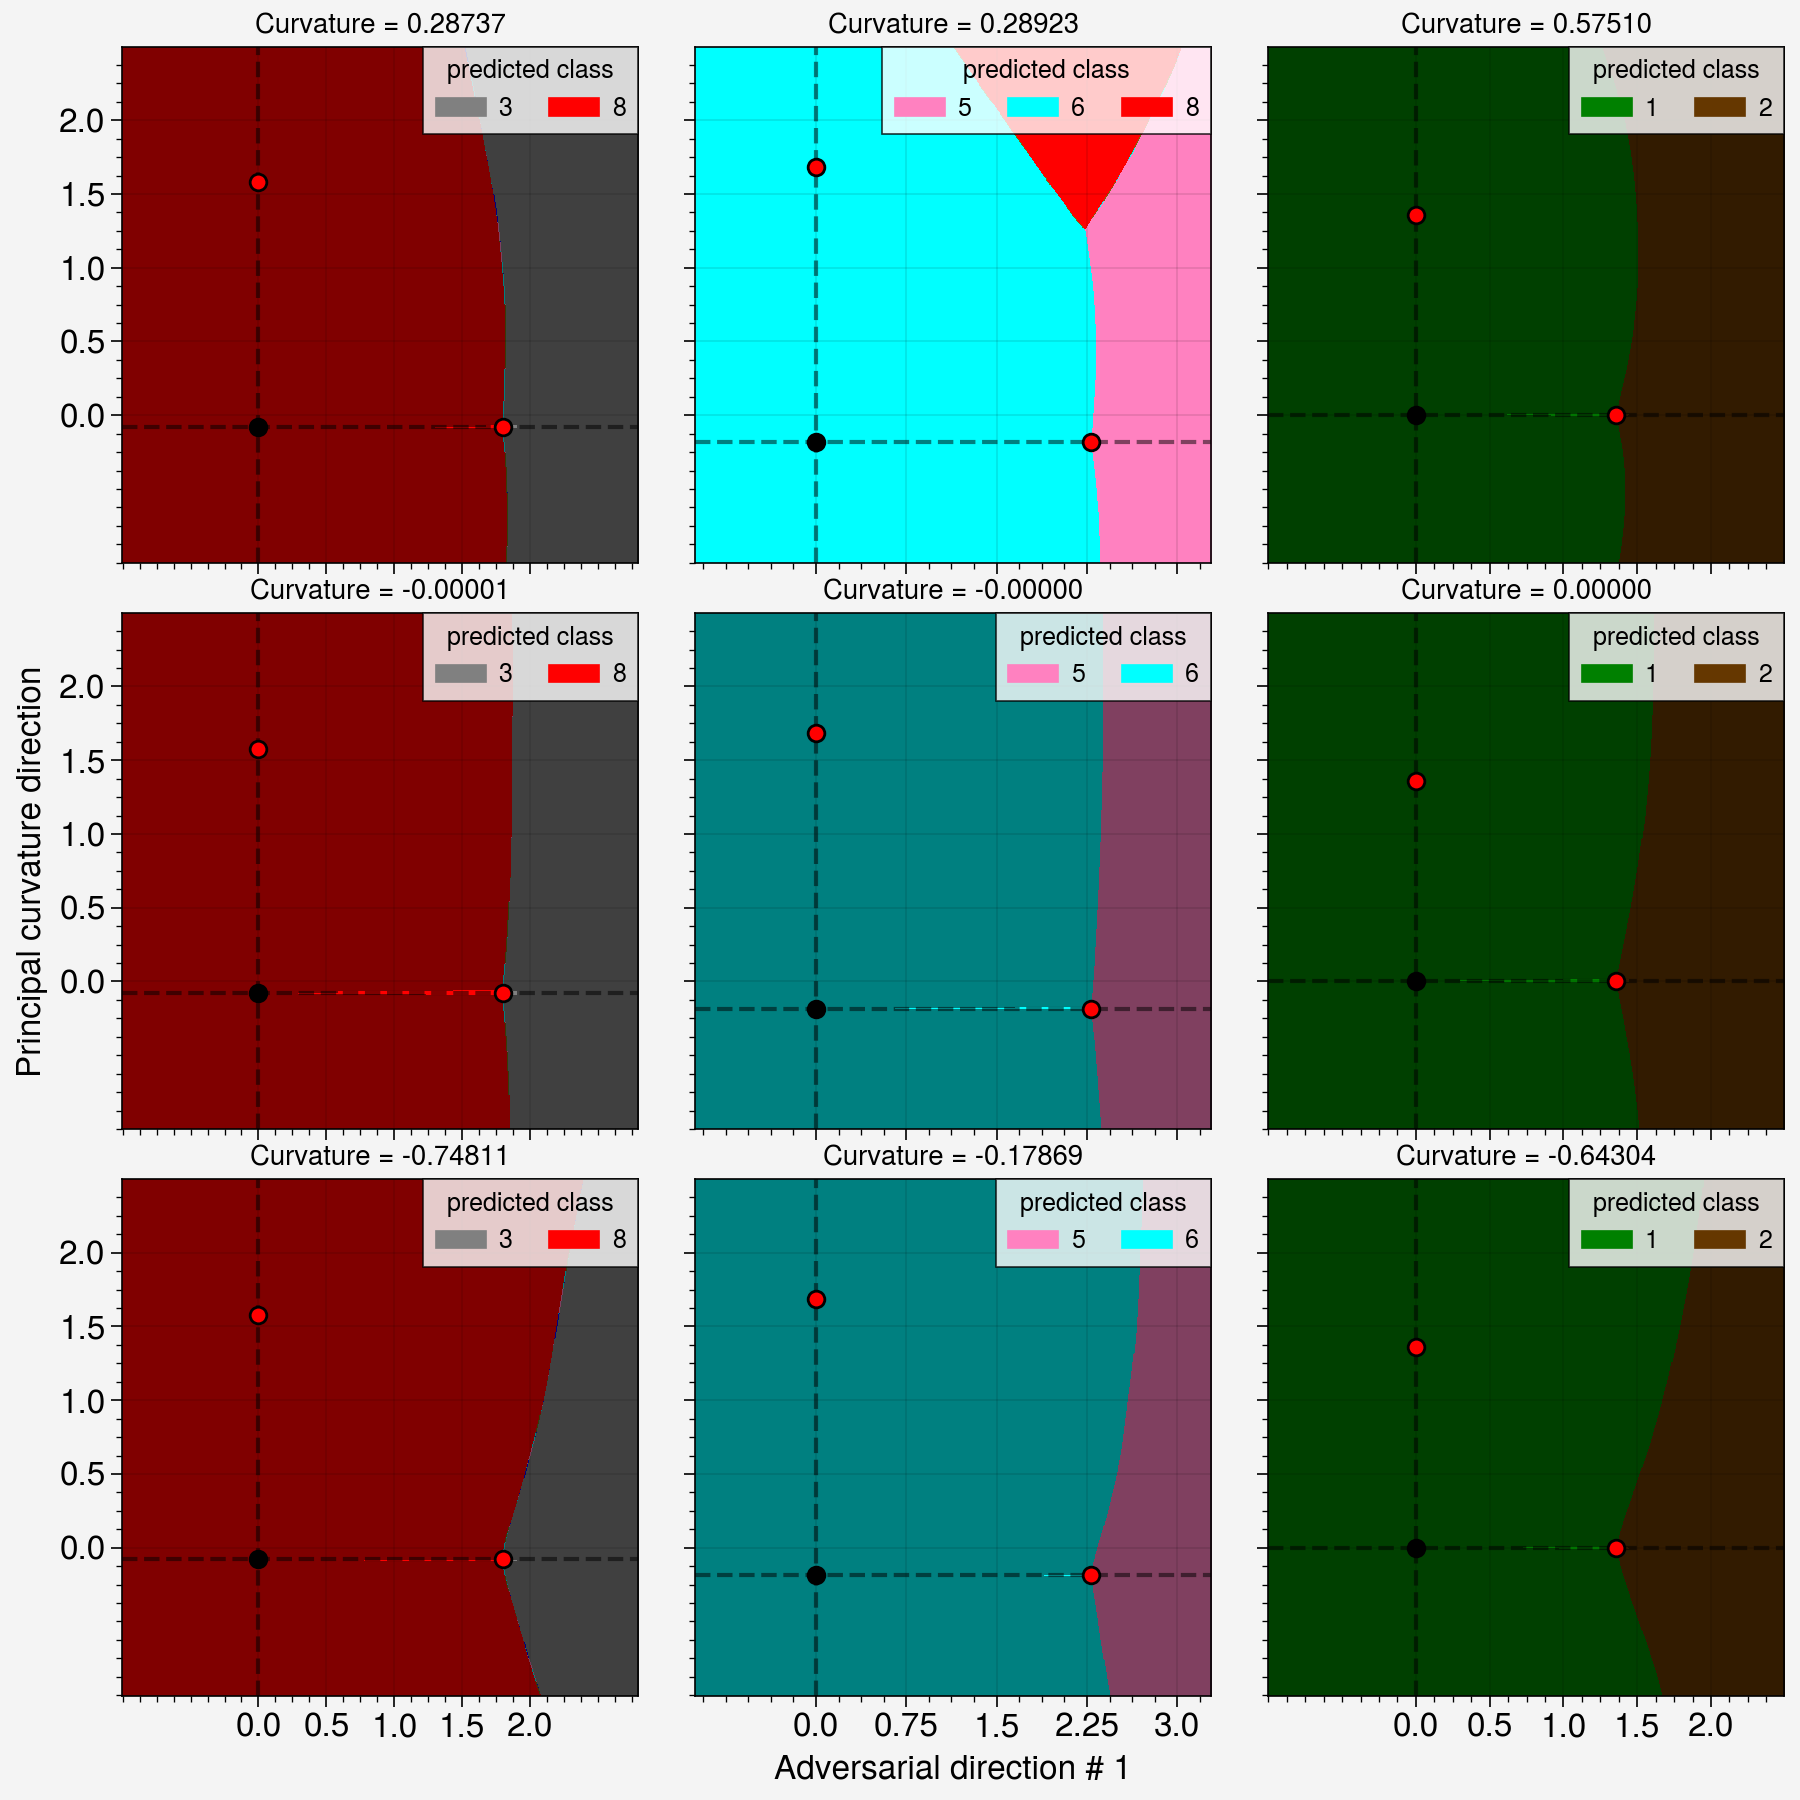

In [13]:
# TODO:
# y & x axis should be the same scale
# no need to have a dot on the y axis, should use an arrow instead
num_plot_images = 3
offset = 0
figsize = 9

aspect = 3 / num_plot_images

for model_idx, (model_, data_) in enumerate(zip([model_natural, ], [data_natural, ])):
    num_models, num_images, num_advs, num_directions, num_pixels = adv_principal_directions.shape
    
    fig, axs = pplt.subplots(nrows=3, ncols=num_plot_images, figsize=(figsize, figsize*aspect), hspace=2, wspace=2)
    axs.format(
        fontsize = 12,
        ylabel = 'Principal curvature direction'
    )
    for image_idx in range(offset, offset+num_plot_images):
        #adv_idx = np.random.randint(low=0, high=num_advs)
        most_flat_index = np.argmin(np.abs(adv_principal_curvatures[model_idx, image_idx, adv_idx, :]))
        curvature_indices = [0, most_flat_index, -1]
        dataset_image_idx = adv_origin_indices[model_idx][image_idx]
        origin = data_['images'][dataset_image_idx, ...]

        boundary_image = get_paired_boundary_image(
            model=model_,
            origin=origin,
            alt_image=data_['advs'][dataset_image_idx, adv_idx, ...],
            num_steps_per_iter=num_steps_per_iter,
            num_iters=num_iters
        )[0]
        boundary_dist = np.linalg.norm(boundary_image.reshape(-1) - origin.reshape(-1))

        for ax_idx, curvature_idx in enumerate(curvature_indices):
            ax = axs[ax_idx, image_idx-offset]
            adv1 = boundary_image.reshape(-1)
            principal_direction = adv_principal_directions[model_idx, image_idx, adv_idx, :, curvature_idx]
            adv2 = origin.reshape(-1) + boundary_dist * principal_direction
            pl.plot_dec_space(origin[None, ...], adv1, adv2, model_, offset=1.0,
                              n_grid=100, show_legend=True, show_advs=True, overlay_inbounds=True, ax=ax)
            ax.format(
                title=f'Curvature = {adv_principal_curvatures[model_idx, image_idx, adv_idx, curvature_idx]:.5f}',
                xlabel=f'Adversarial direction # {adv_idx}',
            )
    plt.show()
    #fig.savefig(f'../data/curvature_visualizations_4.png', transparent=True, bbox_inches='tight', pad_inches=0.01)